# Mendelian diseases genomic regions analysis

Reference Genome: 

Mendelian Diseases positions:

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Auxiliar Fxns

In [32]:
def plot_region_counts(chromosome: str, counts: dict) -> plt.figure:
    labels = counts.keys()
    sizes = counts.values()
    colors = cm.tab10.colors 
    fig, ax = plt.subplots()
    ax.pie(
        sizes,
        labels= labels,
        colors= colors,
        autopct= '%1.1f%%',
        startangle= 90
    )
    ax.set_title(f'Chromosome {chromosome}')
    return fig

def load_gff(file_path: str) -> pd.DataFrame:
    columns = ["seqnames", "feature", "starts", "ends"]
    return pd.read_csv(
        filepath_or_buffer= file_path,
        names= columns,
        header= None,
        sep= '\t',
        comment= '#'
    )

def load_vcf(file_path: str) -> pd.DataFrame:
    columns = ["seqnames", "pos", "id", 'REF', 'ALT']
    return pd.read_csv(
        filepath_or_buffer= file_path,
        names= columns,
        header= None,
        sep= '\t',
        comment= '#',
        dtype= {
            'seqnames': 'string',
            'pos': 'int64',
            'id': 'int64',
            'REF': 'string',
            'ALT' : 'string'
        }
    )

def binary_search(pos: int, genome_regions: pd.DataFrame) -> str:
    search_pool = pd.Index(genome_regions)
    i = 0
    f = len(search_pool)
    while i <= f:
        m = (i + f) // 2
        if pos >= search_pool[m][2] and pos <= search_pool[m][3]:
            return search_pool[m][1]
        elif pos > search_pool[m][3]: #Means its in right region of genome
            i = m + 1
        else:
            f = m - 1
    return 'UNMAPPED'

def get_intergenic_regions(genes_df: pd.DataFrame) -> pd.DataFrame:
    individual_intergenic_regions = []
    for i in range(1, len(genes_df)):
        if genes_df.iloc[i]["seqnames"] == genes_df.iloc[i-1]["seqnames"]:
            intergenic = {
                "seqnames": genes_df.iloc[i - 1]["seqnames"],
                "starts": genes_df.iloc[i - 1]["ends"] + 1,
                "ends": genes_df.iloc[i]["starts"] - 1,
                "feature": "intergenic"
            }
            if intergenic['ends'] >= intergenic['starts']:
                individual_intergenic_regions.append(intergenic)

    intergenic_regions = {
        'seqnames' : [],
        'starts' : [],
        'ends' : [],
        'feature' : []
    }
    for intergen_region in individual_intergenic_regions:
        for feature, value in intergen_region.items():
            intergenic_regions[feature].append(value)
    
    return pd.DataFrame(intergenic_regions)

## Reading GFF

In [3]:
# Ruta al archivo GTF
archivo_gtf = "./../data/trimmed_chr5.gff"

# Cargar el archivo GTF en un DataFrame de pandas
gtf_df = load_gff(archivo_gtf)
gtf_df

,seqnames,feature,starts,ends
0,NC_000005.10,region,1,181538259
1,NC_000005.10,enhancer,10797,11672
2,NC_000005.10,biological_region,10797,11672
3,NC_000005.10,enhancer,12352,12909
4,NC_000005.10,biological_region,12352,12909
...,...,...,...,...
191622,NC_000005.10,match,181301867,181302170
191623,NC_000005.10,match,181328032,181331996
191624,NC_000005.10,match,181333641,181336424
191625,NC_000005.10,match,181378595,181379238


## Subdataframes for genes and genes & exons

In [4]:
# Filtrar por los genes (feature == "gene")
genes_df = gtf_df[gtf_df["feature"] == "gene"]

# Ordenar por cromosoma y posicion de inicio para facilitar el calculo
genes_df = genes_df.sort_values(by=["starts", 'ends']).reset_index(drop= True)
genes_df

,seqnames,feature,starts,ends
0,NC_000005.10,gene,25178,26177
1,NC_000005.10,gene,26321,51003
2,NC_000005.10,gene,92168,189966
3,NC_000005.10,gene,191495,196334
4,NC_000005.10,gene,192728,194727
...,...,...,...,...
2052,NC_000005.10,gene,181261212,181272307
2053,NC_000005.10,gene,181323506,181328195
2054,NC_000005.10,gene,181342142,181370030
2055,NC_000005.10,gene,181418737,181462878


## Intergenic Regions

In [5]:
intergenic_regions = get_intergenic_regions(genes_df= genes_df)
concatenated_df = pd.concat([genes_df, intergenic_regions], ignore_index=True).sort_values(by=["starts", 'ends']).reset_index(drop= True)
concatenated_df

,seqnames,feature,starts,ends
0,NC_000005.10,gene,25178,26177
1,NC_000005.10,intergenic,26178,26320
2,NC_000005.10,gene,26321,51003
3,NC_000005.10,intergenic,51004,92167
4,NC_000005.10,gene,92168,189966
...,...,...,...,...
3595,NC_000005.10,intergenic,181328196,181342141
3596,NC_000005.10,gene,181342142,181370030
3597,NC_000005.10,intergenic,181370031,181418736
3598,NC_000005.10,gene,181418737,181462878


## Mutations

In [19]:
mutations_vcf = load_vcf('./../data/clinvar_trimmed.vcf').sort_values(by=['pos']).reset_index(drop= True)
mutations_positions = list(mutations_vcf['pos'])
mutations_vcf

,seqnames,pos,id,REF,ALT
0,MT,73,3066071,A,G
1,MT,235,1344497,A,G
2,MT,247,1343827,GA,G
3,MT,263,441147,A,G
4,MT,513,1344552,GCA,G
...,...,...,...,...,...
2705443,1,248917965,2355938,G,C
2705444,1,248917978,2308301,G,T
2705445,1,248918022,2295249,A,T
2705446,1,248918194,2483210,G,A


## Mutations Mapping

In [ ]:
counts = {
    'intergenic' : 0,
    'gene' : 0,
    'unmapped' : 0
}
for i, pos in enumerate(mutations_positions):
    print(f'Mapping mutation {i + 1}/{len(mutations_positions)} ...')
    counts[binary_search(pos, concatenated_df)] += 1

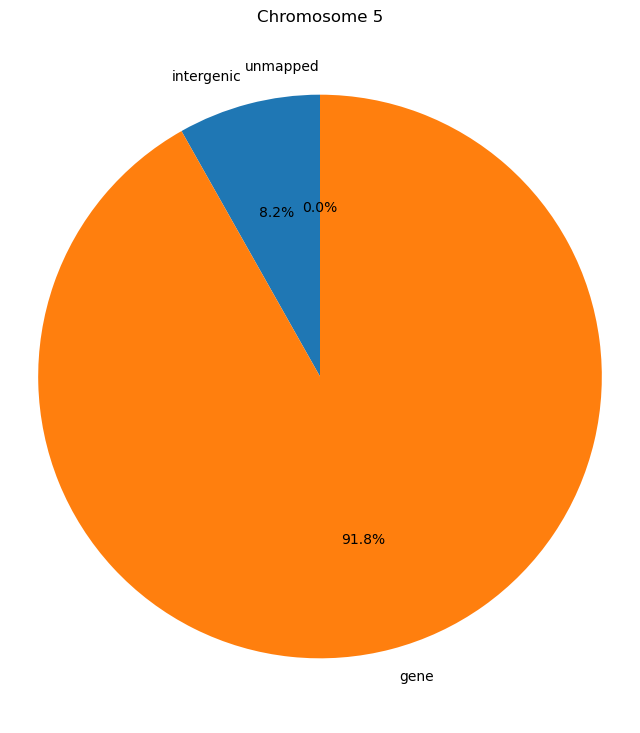

In [8]:
plot_region_counts(
    chromosome= 5,
    counts= counts
);

## Main function

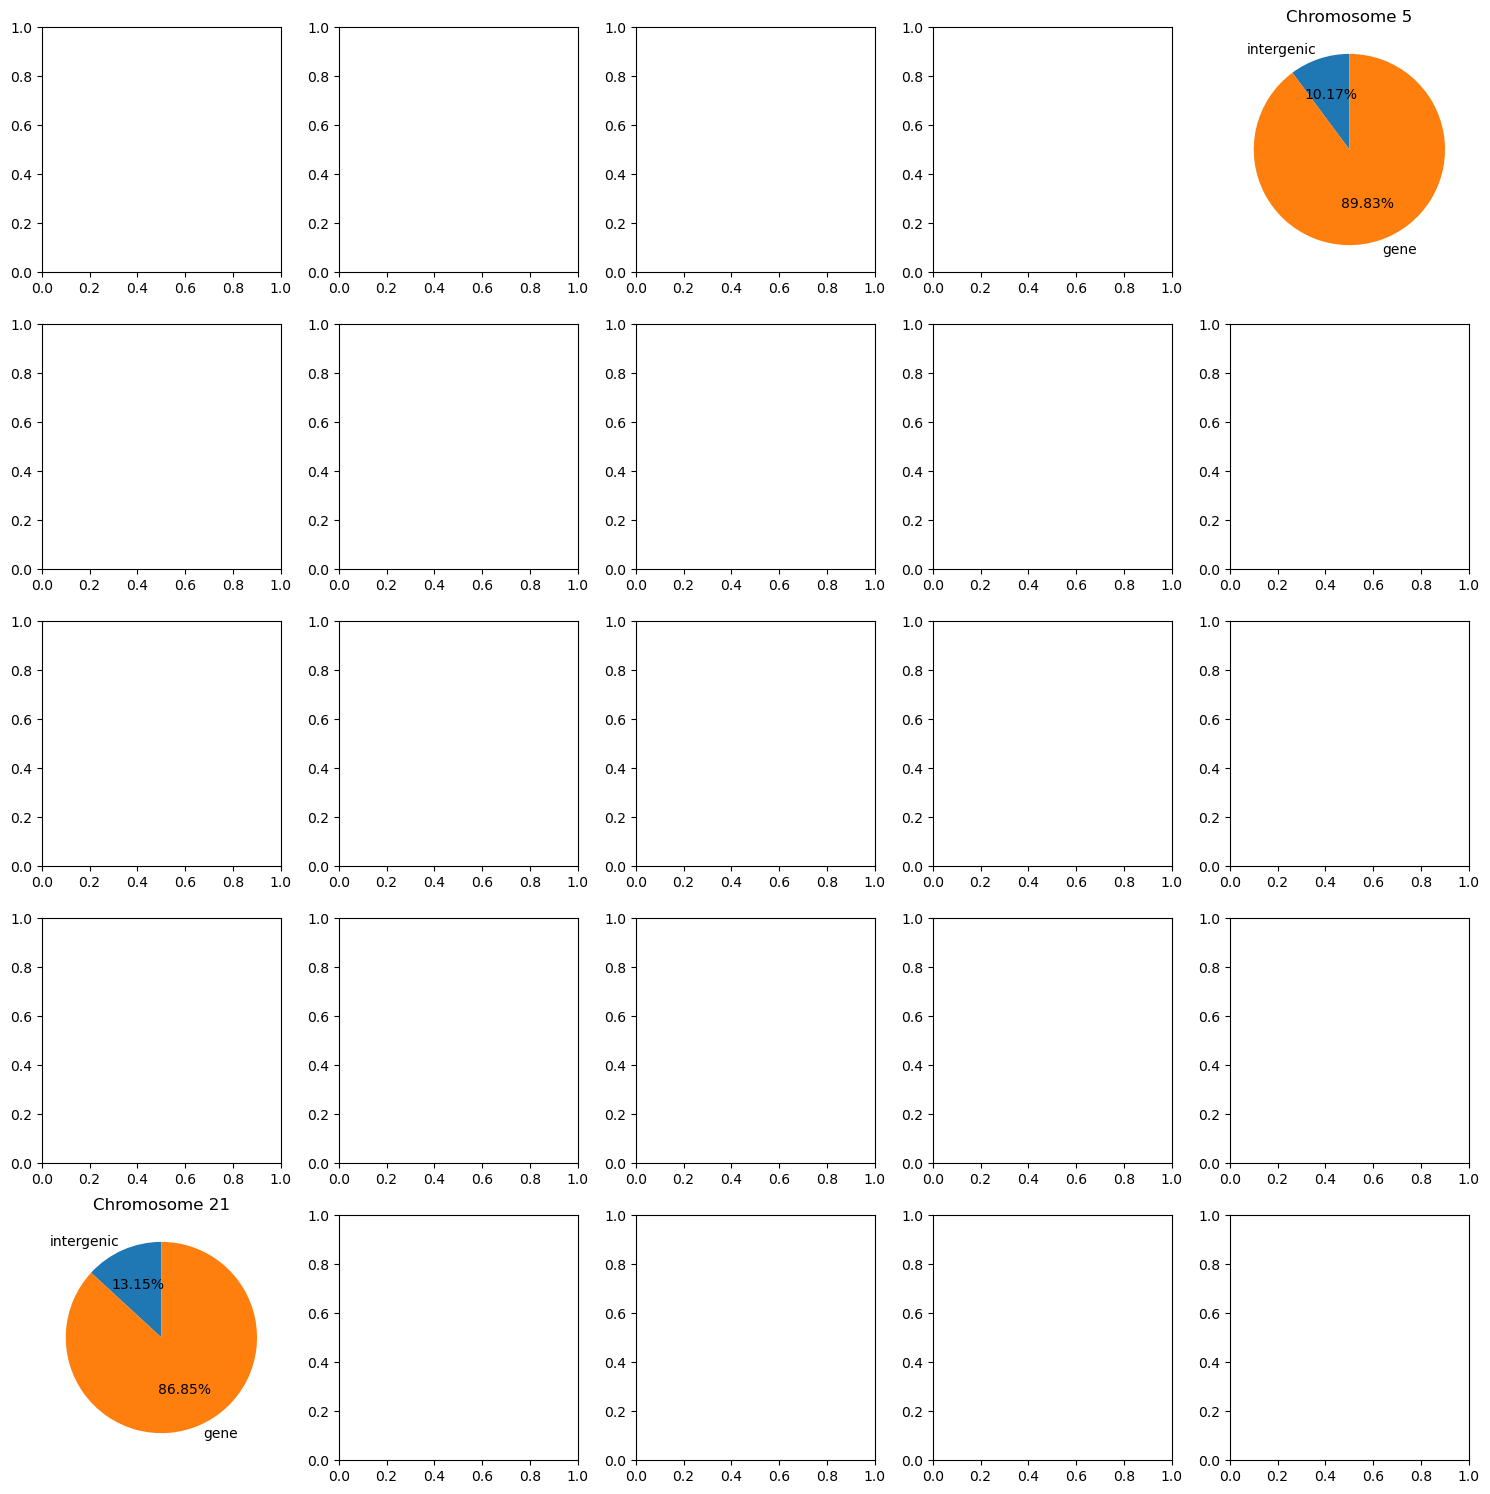

In [42]:
def get_genomic_regions(reference_genome: str, mutations: str, verbose= None):
    refseqs = {
        '1': 'NC_000001.11',
        '2': 'NC_000002.12',
        '3' : 'NC_000003.12',
        '4' : 'NC_000004.12',
        '5' : 'NC_000005.10',
        '6' : 'NC_000006.12',
        '7' : 'NC_000007.17',
        '8' : 'NC_000008.11',
        '9' : 'NC_000009.12',
        '10' : 'NC_000010.11',
        '11' : 'NC_000011.10',
        '12' : 'NC_000012.12',
        '13' : 'NC_000013.11',
        '14' :'NC_000014.9',
        '15' : 'NC_000015.10',
        '16' : 'NC_000016.10',
        '17' : 'NC_000017.11',
        '18' : 'NC_000018.10',
        '19' : 'NC_000019.10',
        '20' : 'NC_000020.11',
        '21' : 'NC_000021.9',
        '22' : 'NC_000022.11',
        'X' : 'NC_000023.11',
        'Y' : 'NC_000024.10',
        'MT' : 'NC_012920.1'
    }

    gff_df = load_gff(reference_genome)
    mutations_df = load_vcf(mutations).sort_values(by=['pos']).reset_index(drop= True)

    fig, axs = plt.subplots(5, 5, figsize=(15, 15))

    for i, chr in enumerate(refseqs.keys()):
        if chr == '21' or chr == '5':
            chr_gff = gff_df[gff_df["seqnames"] == refseqs[chr]]
            chr_mutations = mutations_df[mutations_df['seqnames'] == chr]
            mutations_positions = list(chr_mutations['pos'])

            # Filter only genes regions
            genes_df = chr_gff[chr_gff["feature"] == "gene"]
            genes_df = genes_df.sort_values(by=["starts", 'ends']).reset_index(drop= True)

            # Get intergenic regions
            intergenic_regions = get_intergenic_regions(genes_df= genes_df)
            concatenated_df = pd.concat([genes_df, intergenic_regions], ignore_index=True).sort_values(by=["starts", 'ends']).reset_index(drop= True)

            # Mapping regions
            counts = {
                'intergenic' : 0,
                'gene' : 0,
                'unmapped' : 0
            }
            for j, pos in enumerate(mutations_positions):
                if verbose:
                    print(f'Mapping mutation {j + 1}/{len(mutations_positions)} ...')
                counts[binary_search(pos, concatenated_df)] += 1

            # Plotting
            x = i // 5
            y = i  % 5
            plt.sca(axs[x, y])

            labels = counts.keys()
            sizes = counts.values()
            non_zero_sizes = [size for size in sizes if size != 0]
            non_zero_labels = [label for label, size in zip(labels, sizes) if size != 0]
            colors = cm.tab10.colors 
            plt.pie(
                non_zero_sizes,
                labels= non_zero_labels,
                colors= colors,
                autopct= '%1.2f%%',
                startangle= 90
            )
            plt.title(f'Chromosome {chr}')
            plt.tight_layout()

    plt.show()

# Ruta al archivo GTF
archivo_gtf = "./../data/GRCH38.p14_trimmed.gff"
archivo_vcf = './../data/clinvar_trimmed.vcf'
get_genomic_regions(
    reference_genome= archivo_gtf,
    mutations= archivo_vcf
)
